# Multiple Imputations with TABNET - MITABNET 

## Missing Data in RWE studies

One of the biggest challenges when working with Real World Data is how to handle missing data. Missing data appear as gaps in the data set that hide meaningful values for analysis. Hence, excluding the underlying value of missing data may completely invalidate the results. There are several other practical implications when missing data are present; for example, it can lower the power and affect the precision of parameter estimates' confidence intervals. 

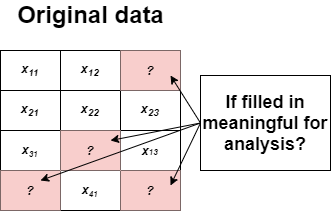

## Multiple imputations

A conventional ad-hoc method to handle missing data is the complete case analysis, to delete any rows or columns with missing variables. The problem with complete case analysis is that it squanders information reducing the sample size considerably. Imputation algorithms are general strategies that replace missing values (n.a.) with plausible values. Nevertheless, replacing missing values with static values cannot be correct in general. After all, imputed values are estimated, not observed. Therefore, it is often more appropriate to apply a random variable approach to represent missing values. Don Rubin proposed multiple imputations (MI) for survey non-responders to tackle the uncertainty in the missing values that single imputation cannot represent with a point estimate.  The general idea of MI is to generate multiple complete datasets, analyse each dataset separately, and summarise the results.

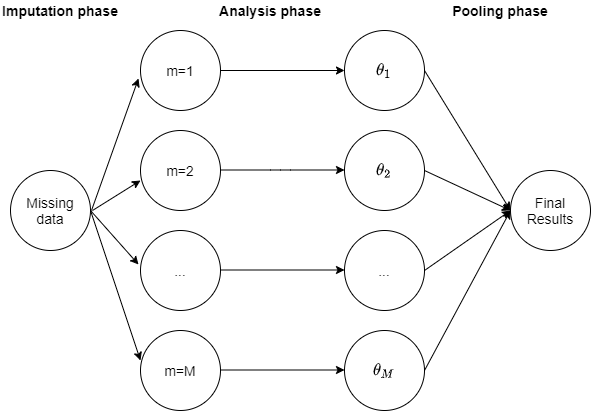

## MITABNET

Neural networks traditionally work with continuous numerical data. For example, for image classification, NN uses the intensity of each pixel, basically a continuous measurement, a number between 0 and 255. Tabnet is a front-end deep learning architecture that can handle mixed data types. At the time of writing, Tabnet is a developing algorithm published in the preprint paper Attentive Interpretable Tabular Learning (Arik, S. O., & Pfister, T. (2019)). 

Tabnet takes the raw input features and applies Drop Out and Batch Normalisation. Then, there are consecutive steps that are identical. Each step starts with a Feature Transformer Block, followed by an Attentive Transformer Block that creates the mask, its output is passed to another Feature Transformer Block, which creates both predictions and the input for the next step's Attentive Transformer Block. The predictions are the sum of the step's outputs, passed to a final fully connected layer to resolve any regression or classification problems. Moreover, we can use each step's mask to provide information about the feature's attributes.

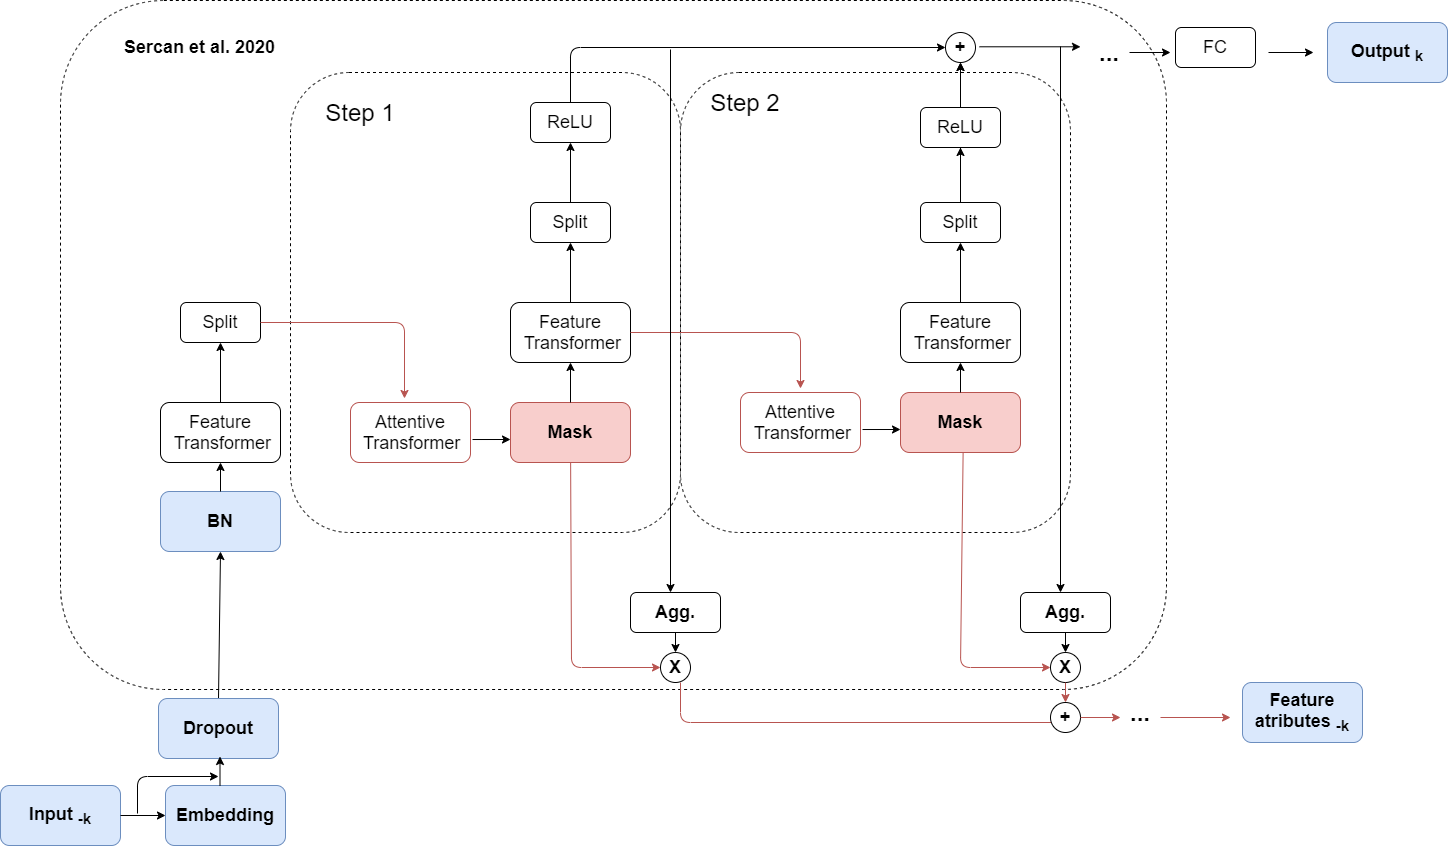

Developing the imputation model was done sequentially, starting with random draws from the observed data $X^{obs}_j$. The MITABNET algorithm, is repeated for each $m = 1, \dots, M$ imputed datasets as follows: 

Step I: Initialise the complete dataset with random samples from the observed dataset $X^{obs}$.

Step II: For each variable, split the missing and observed data sets, split the observations into train and validation sets, we recommend 80:20, use Tabnet to learn the distribution $P(X_j|X_{-j}, R, \theta)$.

Step III: Use the trained Tabnet to predict the missing values in $X_j$.

Step I to III are repeated a prespecified number of iterations for each $K$ feature with missing values.



## Example

In [19]:
import sys
import os
from pathlib import Path
from sklearn.metrics import mean_squared_error
from pytorch_tabnet_dropout.tab_model import TabNetRegressor
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

### Load data and split

In [7]:
# read data
data_dir = "example-data/"
perc = 0.78
x  = pd.read_csv( os.path.join(data_dir, 'x.csv') )
ry = pd.read_csv( os.path.join(data_dir, 'ry.csv') )
wy = pd.read_csv( os.path.join(data_dir, 'wy.csv') )
y  = pd.read_csv( os.path.join(data_dir, 'y.csv') )
y = y.values
x = x.values
ry = (ry.values)[:,0]
wy = (wy.values)[:,0]
xobs = x[ry, :]
xmis = x[wy, :]
yobs = y[ry]

Set = np.random.choice(["train", "valid"], p =[perc, 1-perc], size=len(yobs))
X_train = xobs[Set == "train"]
X_valid = xobs[Set == "valid"]
y_train = yobs[Set == "train"]
y_valid = yobs[Set == "valid"]

### Pre-train network

In [10]:
# train unsupervised model
from pytorch_tabnet.pretraining import TabNetPretrainer

unsupervised_model = TabNetPretrainer(
  optimizer_fn=torch.optim.Adam,
  optimizer_params=dict(lr=2e-2),
  mask_type='entmax' # "sparsemax"
)

max_epochs = 2 if not os.getenv("CI", False) else 2

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=20,
    batch_size=512, virtual_batch_size=64,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8)

Device used : cpu
epoch 0  | loss: 2.24741 | val_0_unsup_loss: 1.31391 |  0:00:08s
epoch 1  | loss: 1.03003 | val_0_unsup_loss: 1.45533 |  0:00:16s
Stop training because you reached max_epochs = 2 with best_epoch = 0 and best_val_0_unsup_loss = 1.31391
Best weights from best epoch are automatically used!


### Set network parameters

In [11]:
# train supervised model for target imputations
clf = TabNetRegressor(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, 
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       dropout = 0.1 # CV suggest that dropout of 0.1 is optimal for MITABNET
                       )

Device used : cpu


### Training

In [13]:
clf.fit(X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=256, virtual_batch_size=64,
    num_workers=0,
    drop_last=False) 


epoch 0  | loss: 0.05957 | train_rmse: 0.23988 | valid_rmse: 0.24421 |  0:00:08s
epoch 1  | loss: 0.05819 | train_rmse: 0.23991 | valid_rmse: 0.24338 |  0:00:17s
Stop training because you reached max_epochs = 2 with best_epoch = 1 and best_valid_rmse = 0.24338
Best weights from best epoch are automatically used!


### Imputations

In [14]:
pred = clf.predict(xmis)
pred



array([[0.06580217],
       [0.0509835 ],
       [0.09427317],
       ...,
       [0.05989658],
       [0.03896365],
       [0.09046576]], dtype=float32)

### Explainability

In [15]:
clf.feature_importances_

array([0.14644196, 0.06193826, 0.12344543, 0.33754658, 0.04619791,
       0.28442986])

In [17]:
explain_matrix, masks = clf.explain(xmis)


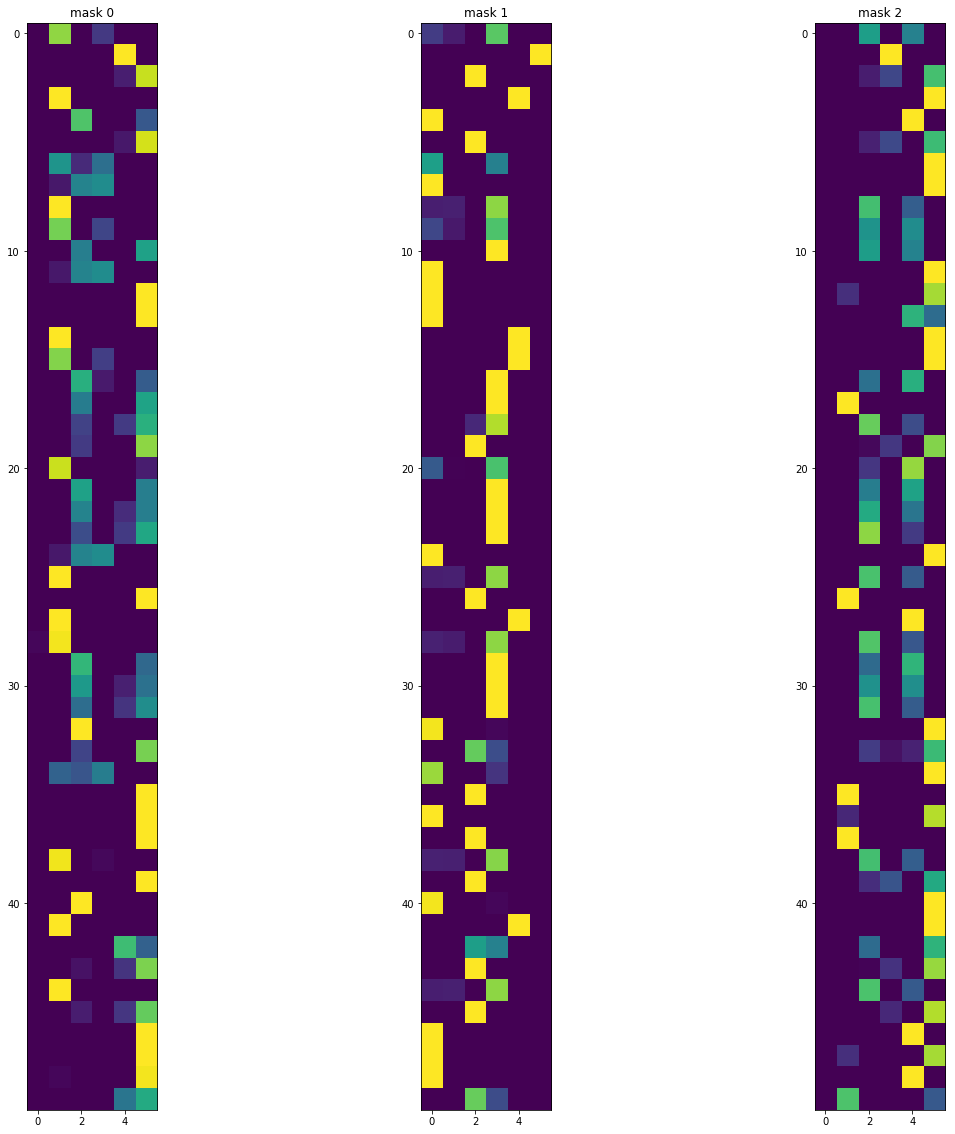

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")